In [1]:
# Imports
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../../lib/python')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs
from ncbi_remap.prealn_wf import srr_per_srx, calculate_corr_among_srr

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_merge_srr')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../../sra.h5', mode='r')

last updated: 2017-11-13 
Git hash: 2b98e197c878f9d5565b71efd6b7c6a1dfa88c37


In [2]:
# Constants

# Merging SRXs

## Number of SRRs Per SRX

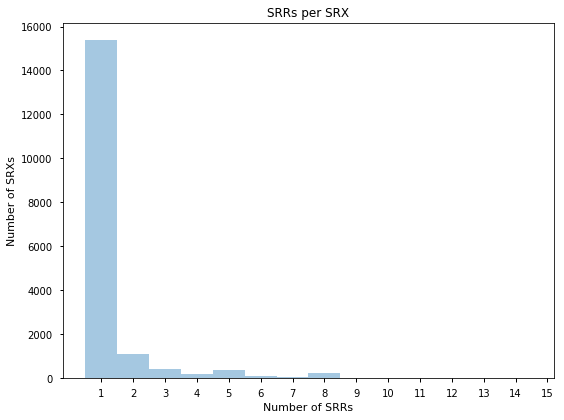

In [3]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('histogram_number_srr_per_srx'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = srr_per_srx(store).iloc[:, 0]
    bins = list(range(1, df.value_counts().index.max() + 1))
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df, bins=bins, ax=ax, kde=False, hist_kws={'align': 'left'})
    ax.set_title('SRRs per SRX')
    ax.set_ylabel('Number of SRXs')
    ax.set_xlabel('Number of SRRs')
    ax.set_xticks(bins)
    return fig

plot(store)

In [4]:
# Make Flags
srx_counts = srr_per_srx(store)
single_srr_srx = srx_counts[(srx_counts == 1)['srr']].index.tolist()
two_srr_srx = srx_counts[(srx_counts == 2)['srr']].index.tolist()
multi_srr_srx = srx_counts[(srx_counts > 2)['srr']].index.tolist()

# Table of counts
df_num_srr = srx_counts.srr.value_counts().apply(lambda x: '{:,}'.format(x)).to_frame()
df_num_srr.index.name = 'Number of SRR'
df_num_srr.columns=['Number SRXs']
df_num_srr

,Number SRXs
Number of SRR,
1,"15,403"
2,"1,120"
3,416
5,360
8,222
4,186
6,84
7,59
9,14


In [6]:
@memory.cache
def calc_corr(srxs, multi='m1', show_warn=True):
    dfs = []
    for srx in srxs:
        dfs.extend(calculate_corr_among_srr(store, srx, multi=multi, show_warn=show_warn))
        
    return pd.DataFrame(dfs, columns=['srx', 'srrs', 'corr'])

In [7]:
df = calc_corr(store['prealn/complete'].srx.unique().tolist(), multi='m2', show_warn=False)

In [8]:
# Remove SRX with out corrs
nona = df.dropna()

# Group by SRX and make lists for twos and multis
grps = nona.groupby('srx').srrs.count()
twos = nona.srx.isin(grps[grps == 1].index)
multi = nona.srx.isin(grps[grps > 1].index)

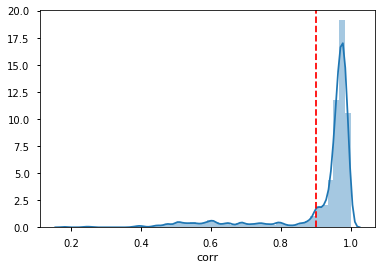

In [9]:
# plot twos
fig, ax = plt.subplots(1, 1)
sns.distplot(nona.loc[twos, 'corr'], ax=ax)
ax.axvline(0.90, ls='--', color='r')

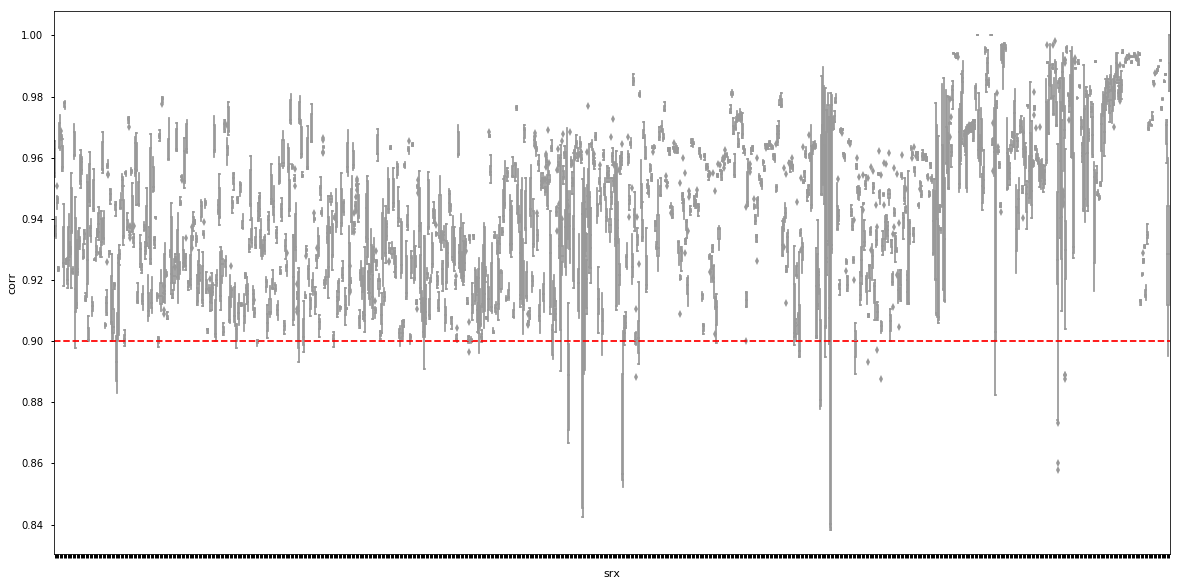

In [10]:
# Plot multis
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot('srx', 'corr', data=nona[multi], color='white', ax=ax)
ax.set_xticklabels([]);
ax.axhline(.90, ls='--', color='r')

## Mapping similarity among SRX

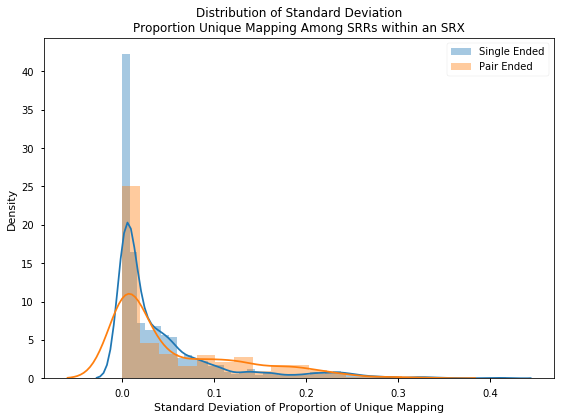

In [17]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('distplot_std_unique_mapping'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    from ncbi_remap.prealn_wf import srr_per_srx
    srx_counts = srr_per_srx(store)
    multi_srr_srx = srx_counts[(srx_counts > 1)['srr']].index.tolist()

    se = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_unpaired', 
                                          'num_uniquely_aligned']].copy()
    se.dropna(inplace=True)
    se.reset_index(inplace=True)
    se['prop_unique_aligned'] = se['num_uniquely_aligned'] / se['num_reads']
    se = se[se.srx.isin(multi_srr_srx)]

    pe = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_paired', 
                                             'num_concordant_reads_uniquely_aligned']].copy()
    pe.dropna(inplace=True)
    pe.reset_index(inplace=True)
    pe['prop_unique_aligned'] = pe['num_concordant_reads_uniquely_aligned'] / pe['num_reads']
    pe = pe[pe.srx.isin(multi_srr_srx)]

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.groupby('srx')['prop_unique_aligned'].std(), ax=ax, label='Single Ended')
    sns.distplot(pe.groupby('srx')['prop_unique_aligned'].std(), ax=ax, label='Pair Ended')
    ax.legend()
    
    ax.set_title('Distribution of Standard Deviation\nProportion Unique Mapping Among SRRs within an SRX')
    ax.set_xlabel('Standard Deviation of Proportion of Unique Mapping')
    ax.set_ylabel('Density');
    
    return fig

plot(store)